In [1]:
import brainlit
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.viz.swc import *
from brainlit.algorithms.generate_fragments import tube_seg

In [2]:
# Optional: Print the IDs of segments in Neuroglancer
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
ngl_skel = NeuroglancerSession(url+"_segments", mip=1)
working_ids = []
for seg_id in range(10): #most segment IDs in range(300), additionally, segments 999, 1000 are available
    try:
        segment = ngl_skel.cv.skeleton.get(seg_id)
        working_ids.append(seg_id)
    except:
          pass
print(working_ids)

Downloading: 100%|██████████| 1/1 [00:00<00:00, 27.38it/s]

[2, 7]


In [31]:
seg_id = 13
mip = 2
df = read_s3(url+"_segments", seg_id, mip)
#df.head()
df['sample'].size # the number of vertex IDs [1, 2, ..., df['sample'].size]

Downloading: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/brainlit/viz/swc.py:46: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  delim_whitespace=True,


3135

In [32]:
print(df)

      sample  structure       x       y       z    r  parent
0          1          0  1416.0  1634.0  2364.0  1.0      -1
1          2          0  1427.0  1628.0  2361.0  1.0       1
2          3         64  1441.0  1621.0  2355.0  1.0       2
3          4        192  1456.0  1612.0  2348.0  1.0       3
4          5          0  1462.0  1602.0  2343.0  1.0       4
5          7          0  1472.0  1595.0  2339.0  1.0       5
6         13          0  1496.0  1591.0  2330.0  1.0       7
7         38          0  1525.0  1593.0  2326.0  1.0      13
8         36          0  1524.0  1571.0  2322.0  1.0      38
9         42          0  1531.0  1566.0  2321.0  1.0      36
10        62         64  1556.0  1560.0  2317.0  1.0      42
11        77        192  1577.0  1558.0  2315.0  1.0      62
12        85          0  1594.0  1552.0  2313.0  1.0      77
13        93          0  1611.0  1546.0  2312.0  1.0      85
14       105         64  1634.0  1539.0  2311.0  1.0      93
15       107        192 

In [33]:
subneuron_df = df[0:5] # choose vertices to use for the subneuron

In [34]:
vertex_list = subneuron_df['sample'].array 

In [35]:
vertex_list

<PandasArray>
[1, 2, 3, 4, 5]
Length: 5, dtype: int64

In [36]:
ngl = NeuroglancerSession(url, mip=mip)
buffer = [10, 10, 10]
img, bounds, vox_in_img_list = ngl.pull_vertex_list(seg_id, vertex_list, buffer = buffer, expand = True)

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]




In [37]:
# Reference: https://github.com/NeuroDataDesign/mouselit/blob/master/bijan/mouse_test/final%20notebook.ipynb

import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import napari


def plot_2d(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        c = nda.shape[-1]

        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1] * 2
    ysize = nda.shape[0] * 2

    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if title:
        plt.title(title)

    plt.show()


def plot_3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    plot_2d(img, title, margin, dpi)


def napari_viewer(img, labels=None, shapes=None, label_name="Segmentation"):
    viewer = napari.view_image(np.squeeze(np.array(img)))
    if labels is not None:
        viewer.add_labels(labels, name=label_name)
    if shapes is not None:
        viewer.add_shapes(data=shapes, shape_type='path', edge_color='blue', name='Skeleton')
    return viewer

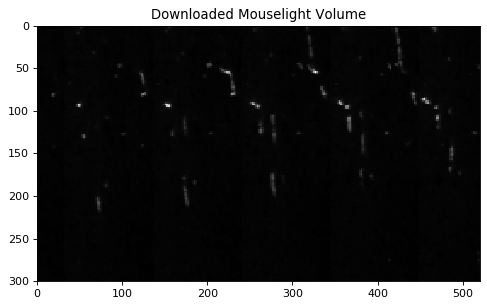

In [38]:
%gui qt
plot_3d(sitk.GetImageFromArray(np.squeeze(img), isVector=False), zslices=range(48,53), title = "Downloaded Mouselight Volume")
napari_viewer(img)

In [39]:
corrected_subneuron_df = subneuron_df
for index, sample in enumerate(vox_in_img_list):
    corrected_subneuron_df['x'][index] = sample[0]
    corrected_subneuron_df['y'][index] = sample[1]
    corrected_subneuron_df['z'][index] = sample[2]
print(corrected_subneuron_df)

/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pa

   sample  structure     x      y     z    r  parent
0       1          0  55.0   46.0  34.0  1.0      -1
1       2          0  50.0   60.0  35.0  1.0       1
2       3         64  54.0   81.0  35.0  1.0       2
3       4        192  50.0   91.0  34.0  1.0       3
4       5          0  47.0  111.0  36.0  1.0       4


In [40]:
print(img.sum())

6292324902


In [41]:
G = df_to_graph(corrected_subneuron_df)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('\n')
print('Sample 1 coordinates (x,y,z)')
G.nodes[1]

Number of nodes: 5
Number of edges: 4


Sample 1 coordinates (x,y,z)


{'x': 55, 'y': 46, 'z': 34}

In [42]:
paths = graph_to_paths(G)
len(paths)

1

In [43]:
%gui qt
napari_viewer(img, shapes=paths)

In [44]:
# seed = []
# for sample in vox_in_img_list:
#     _, s = adaptive_thresh.get_seed(sample)
#     seed.append(s)
# print(seed)

In [45]:
print(viewer.layers['Skeleton'].data)

[array([[ 55.,  46.,  34.],
       [ 50.,  60.,  35.],
       [ 54.,  81.,  35.],
       [ 50.,  91.,  34.],
       [ 47., 111.,  36.]])]


In [46]:
labels = tube_seg.tubes_seg(img, vox_in_img_list, 2)

In [48]:
## Most useful visualization cell - contains image, SWC, and automatic segmentation
%gui qt
napari_viewer(img, labels=labels, shapes=paths, label_name="Tube Segmentation")

## Steps to Manually Edit Labels
1. Ensure Napari is in 2D-slice viewing, not 3D view. (The second button from the bottom left)
2. Click the image layer and adjust the contrast limits as desired.
3. Click the "Confidence-Connected Threshold Layer"
4. Click the paintbrush tool and adjust the brush size. Ensure that "label" is set to 1 to paint and 0 to erase.
5. Click and drag on the image to adjust labels. Changes are saved automatically, and CMD-Z to undo is supported.

In [49]:
# Get manual labels
manual_labels = viewer.layers["Tube Segmentation"].data

In [50]:
# Upload segmentation to AWS
ngl_upload = NeuroglancerSession(url+"_seg", mip=mip)

In [51]:
%%capture
ngl_upload.push(manual_labels, bounds);

In [52]:
downloaded_labels = ngl_upload.pull_bounds_seg(bounds)

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]




In [53]:
print(np.all(manual_labels == downloaded_labels))

True
